# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools
from shapely.geometry import box
import geopandas as gpd

### Importing territorial boundry of Auckland region

In [2]:
# Extract coordinates
min_x, min_y, max_x, max_y = 174.489515, -37.159816, 175.258558, -36.570920

# Create polygon from bounding box coordinates
polygon = box(min_x, min_y, max_x, max_y)

# If you still need the GeoDataFrame for other purposes:
gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
polygon_geom = gdf.iloc[0]['geometry']  # Extract the actual geometry object if needed

In [3]:
Gwalk_auck = ox.graph.graph_from_polygon(polygon_geom, network_type="walk", simplify=True, retain_all=True, truncate_by_edge=True)

### Generating the road network

In [4]:
Gwalk_auck.graph

{'created_date': '2024-11-11 13:11:37',
 'created_with': 'OSMnx 1.9.3',
 'crs': 'epsg:4326',
 'simplified': True}

In [ ]:
# Add speed and travel time
Gwalk_auck = ox.add_edge_speeds(Gwalk_auck)
Gwalk_auck = ox.add_edge_travel_times(Gwalk_auck)
print("added all")

Gwalk_auck = ox.project_graph(Gwalk_auck)
G = ox.simplification.consolidate_intersections(Gwalk_auck, rebuild_graph=True, tolerance=10, reconnect_edges=True)
ox.io.save_graph_geopackage(G, "data/network_analysis/auckland_waiheke_network_walk.gpkg.gpkg")
# G = ox.io.load_graphml("data/network_analysis/auckland_waiheke_network_walkConsolidated.graphml")

added all


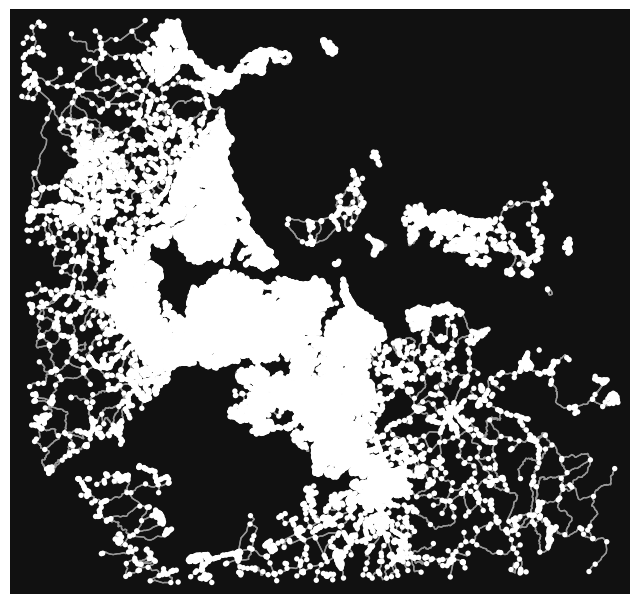

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
ox.plot.plot_graph(G)

In [10]:
Gdrive_auck = ox.graph.graph_from_polygon(polygon_geom, network_type="drive", simplify=True, retain_all=True, truncate_by_edge=True)

# Add speed and travel time
Gdrive_auck = ox.add_edge_speeds(Gdrive_auck)
Gdrive_auck = ox.add_edge_travel_times(Gdrive_auck)
Gdrive_auck = ox.project_graph(Gdrive_auck)

G = ox.simplification.consolidate_intersections(Gdrive_auck, rebuild_graph=True, tolerance=10, reconnect_edges=True)
ox.io.save_graph_geopackage(G, "data/network_analysis/auckland_waiheke_network_drive.gpkg")
# G = ox.io.load_graphml("data/network_analysis/auckland_waiheke_network_walkConsolidated.graphml")

In [11]:
Gbike_auck = ox.graph.graph_from_polygon(polygon_geom, network_type="bike", simplify=True, retain_all=True, truncate_by_edge=True)

# Add speed and travel time
Gbike_auck = ox.add_edge_speeds(Gbike_auck)
Gbike_auck = ox.add_edge_travel_times(Gbike_auck)
Gbike_auck = ox.project_graph(Gbike_auck)

G = ox.simplification.consolidate_intersections(Gbike_auck, rebuild_graph=True, tolerance=10, reconnect_edges=True)
ox.io.save_graph_geopackage(G, "data/network_analysis/auckland_waiheke_network_bike.gpkg")
# G = ox.io.load_graphml("data/network_analysis/auckland_waiheke_network_walkConsolidated.graphml")

# Get 3-or-more-way intersections

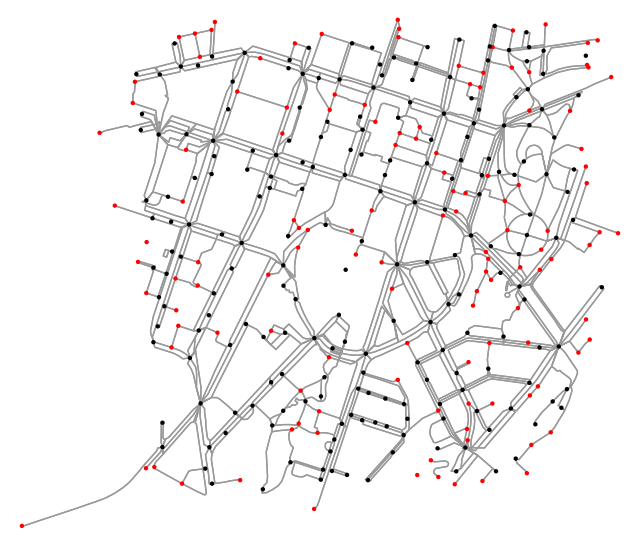

count:  128
stat:  128


In [8]:
G = ox.graph_from_address('Auckland, New Zealand', dist=500, network_type='walk', simplify=True, retain_all=True, truncate_by_edge=True)
G = ox.project_graph(G)
G = ox.simplification.consolidate_intersections(G, rebuild_graph=True, tolerance=10, reconnect_edges=True)

nc = []
count = 0
for n, d in G.nodes(data=True):
    if d['street_count'] >= 3:
        nc.append('#FF0000')
        count += 1
    else:
        nc.append('#000000')
stat = ox.stats.intersection_count(G, min_streets=2)
ox.plot_graph(G, node_size=10, bgcolor='#FFFFFF', node_color=nc, show=True, save=True, filepath='map.png')
print('count: ', count)
print('stat: ', stat)

# Get SA1 data

In [ ]:
import requests
import geopandas as gpd
from pyproj import Transformer

def fetch_auckland_sa1_data(bbox_wgs84):
    """
    Fetch and process SA1 polygons for Auckland urban areas.
    
    Parameters:
    bbox_wgs84 (list): [min_lon, min_lat, max_lon, max_lat] in WGS84 (EPSG:4326)
    
    Returns:
    str: Path to the saved file
    """
    # Convert bbox to NZTM
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:2193", always_xy=True)
    min_x, min_y = transformer.transform(bbox_wgs84[0], bbox_wgs84[1])
    max_x, max_y = transformer.transform(bbox_wgs84[2], bbox_wgs84[3])
    bbox_nztm = [min_x, min_y, max_x, max_y]
    
    # API setup
    base_url = "https://datafinder.stats.govt.nz/services;key=9531f7e1192b4b4380fc777a5af4b04c/wfs/"
    
    # Fetch SA1 polygons
    all_features = []
    start_index = 0
    page_size = 1000
    
    while True:
        params = {
            'service': 'WFS',
            'version': '2.0.0',
            'request': 'GetFeature',
            'typeName': 'layer-111208',
            'outputFormat': 'json',
            'srsName': 'EPSG:2193',
            'bbox': f"{bbox_nztm[0]},{bbox_nztm[1]},{bbox_nztm[2]},{bbox_nztm[3]},EPSG:2193",
            'count': page_size,
            'startIndex': start_index
        }
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            features = response.json().get('features', [])
            
            if not features:
                break
                
            all_features.extend(features)
            start_index += len(features)
            
            if len(features) < page_size:
                break
                
        except Exception as e:
            print(f"Error fetching SA1 data: {e}")
            return None
    
    if not all_features:
        return None
        
    # Create GeoDataFrame from SA1 features
    sa1_gdf = gpd.GeoDataFrame.from_features(all_features)
    sa1_gdf.set_crs(epsg=2193, inplace=True)
    
    # Remove oceanic areas
    sa1_gdf = sa1_gdf[~sa1_gdf['LANDWATER_NAME'].isin(['Oceanic', 'Inlet'])]
    
    # Fetch urban classification
    params = {
        'service': 'WFS',
        'version': '2.0.0',
        'request': 'GetFeature',
        'typeName': 'layer-111198',
        'outputFormat': 'json',
        'srsName': 'EPSG:2193',
        'bbox': f"{bbox_nztm[0]},{bbox_nztm[1]},{bbox_nztm[2]},{bbox_nztm[3]},EPSG:2193"
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        urban_gdf = gpd.GeoDataFrame.from_features(response.json()['features'])
        urban_gdf.set_crs(epsg=2193, inplace=True)
        
        # Spatial join and filter for Auckland urban areas
        sa1_urban = gpd.sjoin(sa1_gdf, urban_gdf, how='left', predicate='within')
        final_gdf = sa1_urban[sa1_urban['UR2023_V1_00_NAME'].isin(['Auckland', 'Waiheke West'])]
        
        # Keep only necessary columns
        final_gdf = final_gdf[['SA12023_V1_00', 'UR2023_V1_00_NAME_ASCII', 'IUR2023_V1_00_NAME', 'geometry']]
        
        # Save to file
        output_file = "data/api_auckland_sa1_urban.gpkg"
        final_gdf.to_file(output_file, driver="GPKG")
        print(f"Saved {len(final_gdf)} SA1 areas to {output_file}")
        
        return output_file
        
    except Exception as e:
        print(f"Error fetching urban classification: {e}")
        return None

# Example usage:
bbox = [174.489515, -37.159816, 175.258558, -36.570920]  # Auckland bbox
output_file = fetch_auckland_sa1_data(bbox)

Saved 8757 SA1 areas to data/api_auckland_sa1_urban.gpkg


# Get parks access points

In [17]:
import osmnx as ox
import geopandas as gpd

# Auckland bbox and minimum area
bbox = [174.489515, -37.159816, 175.258558, -36.570920]  # [west, south, east, north]
min_area_ha = 0.5

# Tags for green spaces
tags = {
    'leisure': ['park', 'garden', 'nature_reserve'],
    'landuse': ['grass', 'recreation_ground', 'meadow'],
    'natural': ['grassland', 'heath']
}

# Get green spaces
green_spaces = ox.features_from_bbox(
    north=bbox[3], 
    south=bbox[1], 
    east=bbox[2], 
    west=bbox[0],
    tags=tags
)

# Convert to NZTM2000 projection and calculate areas
green_spaces = green_spaces.to_crs(epsg=2193)
green_spaces['area_ha'] = green_spaces.geometry.area / 10000
green_spaces = green_spaces[green_spaces['area_ha'] >= min_area_ha]


/var/folders/gk/qnd3k3r95k79msznmhs8kl4r0000gn/T/ipykernel_51054/1105445989.py:16: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  green_spaces = ox.features_from_bbox(


In [27]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, MultiPoint
import pandas as pd

def create_access_points(green_spaces, spacing=250):
    """Generate access points along park boundaries and centroids"""
    
    # Reset index to get element_type and osmid as columns
    green_spaces = green_spaces.reset_index()
    
    # Initialize lists to store points
    boundary_points = []
    centroid_points = []
    element_types = []
    osmids = []
    point_types = []
    
    # Process each park
    for idx, park in green_spaces.iterrows():
        # Get park boundary
        boundary = park.geometry.boundary
        
        # Calculate number of points needed based on boundary length
        boundary_length = boundary.length
        num_points = max(1, int(boundary_length / spacing))
        
        # Generate evenly spaced points along boundary
        distances = np.linspace(0, boundary_length, num_points)
        for distance in distances:
            point = boundary.interpolate(distance)
            boundary_points.append(point)
            element_types.append(park['element_type'])
            osmids.append(park['osmid'])
            point_types.append('boundary')
        
        # Add centroid
        centroid = park.geometry.centroid
        centroid_points.append(centroid)
        element_types.append(park['element_type'])
        osmids.append(park['osmid'])
        point_types.append('centroid')
    
    # Combine all points into a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(
        {
            'geometry': boundary_points + centroid_points,
            'element_type': element_types,
            'osmid': osmids,
            'point_type': point_types
        },
        crs=green_spaces.crs
    )
    
    # Create a copy of green_spaces without geometry for joining
    green_spaces_attrs = green_spaces.drop(columns=['geometry'])
    
    # Join park attributes to points
    points_gdf = points_gdf.merge(
        green_spaces_attrs,
        on=['element_type', 'osmid'],
        how='left'
    )
    
    return points_gdf

# Generate access points
access_points = create_access_points(green_spaces, spacing=250)

# Save the results
access_points.to_file("data/auckland_parks_access_points.gpkg", driver="GPKG")

# Print summary
print(f"Created {len(access_points[access_points.point_type == 'boundary'])} boundary access points")
print(f"Created {len(access_points[access_points.point_type == 'centroid'])} centroids")
print(f"Total points: {len(access_points)}")



Created 12675 boundary access points
Created 2690 centroids
Total points: 15365


# Bus Freqnecy from GTSF

In [6]:
df = pd.read_csv("data/transport/public_transport/GTFS/gtfs_auckland/stop_times.txt",sep=",", encoding="gbk")
df.drop(columns=df.columns[-4:], axis=1,  inplace=True)

In [ ]:
# sum bus departures from bus stops per day
df2 = df.groupby(by='stop_id').count().sort_values(by='arrival_time',ascending=False)

df2['busDepsPerHour'] = df2['departure_time']/24 # get average buses per hour
df2 = df2.loc[df2['busDepsPerHour'] >= 6] #select bus stops with more than 6 buses per hour, approximation of buses every 10 minutes

df2.to_csv("bus_frequency.csv") #save, joining with spatial bus stops was done in QGIS